$$ p_g\left(X_g\right)=\Phi\left(\frac{\gamma_g-w_g X_g}{\sqrt{1-w_g^2}}\right) $$

$$ p_g\left(X_g\right)=\Phi\left(aX_g+b\right) $$

$$ a = \frac{\gamma_g}{\sqrt{1-w_g^2}} $$

$$ b = -\frac{w_g}{\sqrt{1-w_g^2}} $$

The expressions of w and gamma as functions of a and b are:
$$ w_g = -\frac{b}{\sqrt{b^2 + 1}} $$
$$ \gamma_g = a \cdot \sqrt{1 - w_g^2} $$


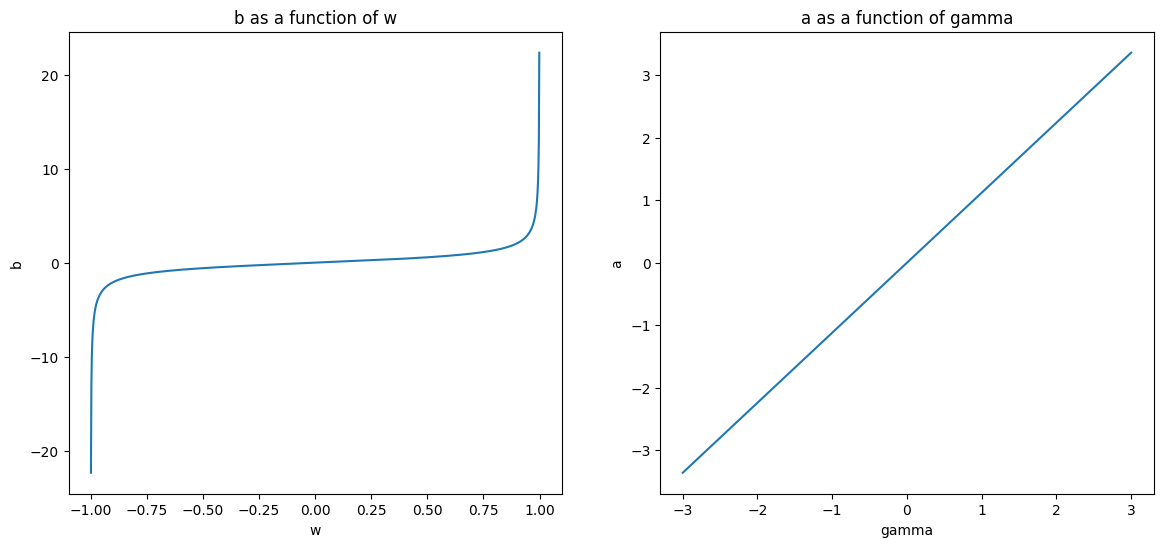

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Plot b value as a function of w if w is between -1 and 1
w = np.linspace(-0.999, 0.999, 1000)
b = w / np.sqrt(1 - w**2)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(w, b)
plt.xlabel("w")
plt.ylabel("b")
plt.title("b as a function of w")

# Plot a value as a function of gamma
gamma = np.linspace(-3, 3, 1000)
w = 0.45
a = gamma / np.sqrt(1 - w**2)

plt.subplot(1, 2, 2)
plt.plot(gamma, a)
plt.xlabel("gamma")
plt.ylabel("a")
plt.title("a as a function of gamma")

plt.show()

In [45]:
def w_calc_func(a, b):
    return -b/ np.sqrt(b**2 + 1)

def gamma_calc_func(a, b):
    return a * np.sqrt(1 - w_calc_func(a, b)**2)

def a_calc_func(w, gamma):
    return gamma / np.sqrt(1 - w**2)

def b_calc_func(w, gamma):
    return -w / np.sqrt(1 - w**2)

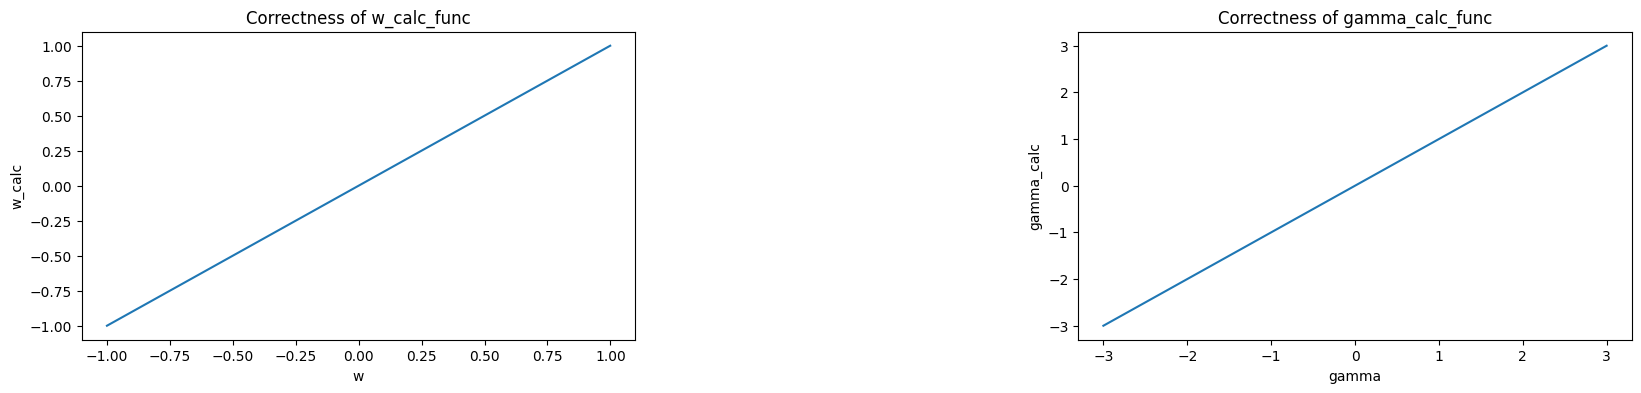

In [61]:

# Check correctness of the w_calc_func
w = np.linspace(-0.999, 0.999, 1000)
b = b_calc_func(w, 0)
w_calculated = w_calc_func(0, b)

plt.figure(figsize=(20, 4))
plt.subplot(1, 2, 1)
plt.plot(w, w_calculated)
plt.xlabel("w")
plt.ylabel("w_calc")
plt.title("Correctness of w_calc_func")

# Check correctness of the gamma_calc_func
gamma = np.linspace(-3, 3, 1000)
a = a_calc_func(0.4, gamma)
b = b_calc_func(0.4, gamma)
gamma_calculated = gamma_calc_func(a, b)

plt.subplot(1, 2, 2)
plt.plot(gamma, gamma_calculated)
plt.xlabel("gamma")
plt.ylabel("gamma_calc")
plt.title("Correctness of gamma_calc_func")

plt.subplots_adjust(wspace=0.8)
plt.show()

In [62]:
gamma_g = -1.65
w_g = 0.35

a = a_calc_func(w_g, gamma_g)
b = b_calc_func(w_g, gamma_g)
print(a, b)

-1.7614096918559583 -0.37363235887853663


In [63]:
w_calc_func(a, b), gamma_calc_func(a, b)

(0.35, -1.65)

In [68]:
from src.data_generator import generate_default_buckets
from src.ML_estimation import calculate_my_likelihood_arr
from scipy.stats import norm, binom
from src.sucess_probability import p_g
from scipy.optimize import minimize
from scipy.integrate import quad

In [69]:
def calculate_variable_changed_likelihood_arr(d_g_arr, n_g_arr, p_g, prob_dens_func, a, b):
    integrand = lambda x: np.prod(binom.pmf(d_g_arr, n_g_arr, norm.cdf(a*x+b))) * prob_dens_func(x)

    result, _ = quad(integrand, -3, 3)

    return result

In [83]:
# convert gamma_list [gamma_1, gamma_2, gamma_3] to [a_1, a_2, a_3]
gamma_list = [-2.9, -2.3, -1.6]
factor_loading_list = [0.45, 0.45, 0.45]
a = [a_calc_func(factor_loading_list[i], gamma_list[i]) for i in range(3)]
b = [b_calc_func(factor_loading_list[i], gamma_list[i]) for i in range(3)]
a, b

([-3.2473765635439547, -2.5755055503969295, -1.7916560350587338],
 [-0.5039032598602688, -0.5039032598602688, -0.5039032598602688])

In [95]:
#seed = 563
#np.random.seed(seed)
# generate default buckets
num_of_obligors_list = [250, 250, 250]
time_points = 100
d_g_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points)
d_g_arr = d_g_list
n_g_arr = np.array(num_of_obligors_list) * time_points
gamma_theory = norm.ppf(d_g_arr / n_g_arr)

In [96]:
%%time
# Different gamma and same factor loading parameter

# MLE condition and initial guess
initial_guess = np.array([-3.247, -2.576, -1.792, -0.50])
bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5)]

# Function to be minimized in weight parameter
objective_function = lambda params: -np.log(calculate_variable_changed_likelihood_arr(d_g_arr, n_g_arr, p_g, norm.pdf, 
                                                                 np.repeat(params[3], 3), 
                                                                 params[0:3]))

result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': True})
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight}")
print(result.message)

Optimization terminated successfully.
         Current function value: 15.168209
         Iterations: 106
         Function evaluations: 187
The optimal weight parameter is [-3.02413257 -2.48632319 -1.85183011 -0.52446646]
Optimization terminated successfully.
CPU times: total: 19.2 s
Wall time: 22.8 s


In [97]:
b_result = result.x[3]
a_result = [result.x[i] for i in range(3)]
w_result = [w_calc_func(a_result[i], b_result) for i in range(3)]
gamma_result = [gamma_calc_func(a_result[i], b_result) for i in range(3)]

w_result, gamma_result

([0.4644634526363541, 0.4644634526363541, 0.4644634526363541],
 [-2.6781484848404498, -2.2018686445053692, -1.6399664631186075])

In [81]:
%%time
# Different gamma and same factor loading parameter

# MLE condition and initial guess
initial_guess = np.array(gamma_theory)
initial_guess = np.append(initial_guess, factor_loading_list[0])
bounds = [(-5, 5), (-5, 5), (-5, 5), (-1, 1)]

# Function to be minimized in weight parameter
objective_function = lambda params: -np.log(calculate_my_likelihood_arr(d_g_arr, n_g_arr, p_g, norm.pdf, 
                                                                 np.repeat(params[3], 3), 
                                                                 params[0:3]))

result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': True})
# Method can be Nelder-Mead or Powell

# The optimal weight parameter
optimal_weight = result.x
print(f"The optimal weight parameter is {optimal_weight}")
print(result.message)

Optimization terminated successfully.
         Current function value: 18.658817
         Iterations: 81
         Function evaluations: 178
The optimal weight parameter is [-2.79226233 -2.24736429 -1.64385825  0.46417663]
Optimization terminated successfully.
CPU times: total: 4.23 s
Wall time: 4.24 s


In [82]:
# Confidence interval for the ML parameter estimation
list_of_len_ts = [80, 160, 320, 500]
num_of_simulations = 100
factor_loading_list = [0.45, 0.45, 0.45]
pd_list = [0.0015, 0.0100, 0.0500]
gamma_list = norm.ppf(pd_list)
num_of_obligors_list = [400, 250, 100]

# Create a dictionary to store the results
# make the keys of the dictionary the length of the time series
results = {key: [] for key in list_of_len_ts}
for _ in range(num_of_simulations):
    for len_ts in list_of_len_ts:
        default_list = generate_default_buckets(factor_loading_list,num_of_obligors_list, gamma_list, time_points=len_ts)
        num_of_obligors_over_time = [x * len_ts for x in num_of_obligors_list]
        d_g_arr = np.array(default_list)
        n_g_arr = np.array(num_of_obligors_over_time)
        a_list = [a_calc_func(factor_loading_list[i], gamma_list[i]) for i in range(3)]
        b_list = [b_calc_func(factor_loading_list[i], gamma_list[i]) for i in range(3)]
        # Let a init the a_list rounded to 3 decimal places
        a_init = np.round(a_list, 3)
        b_init = np.round(b_list, 3)
        
        initial_guess = np.array(a_init)
        initial_guess = np.append(initial_guess, b_init[0])
        bounds = [(-5, 5), (-5, 5), (-5, 5), (-5, 5)]
        objective_function = lambda params: -np.log(calculate_variable_changed_likelihood_arr(d_g_arr, n_g_arr, p_g, norm.pdf, 
                                                                 np.repeat(params[3], 3), 
                                                                 params[0:3]))
        result = minimize(objective_function,
                  initial_guess,
                  method="Nelder-Mead",
                  bounds=bounds,
                  options={
                      'disp': False})
        
        b_result = result.x[3]
        a_result = [result.x[i] for i in range(3)]
        w_result = [w_calc_func(a_result[i], b_result) for i in range(3)]
        gamma_result = [gamma_calc_func(a_result[i], b_result) for i in range(3)]
        
        results[len_ts].append(w_result[0])

C:\Users\kissp\AppData\Local\Temp\ipykernel_17652\2100811897.py:4: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -3, 3)


KeyboardInterrupt: 